In [1]:
import time_shift_corr_coef as tsc
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format ='retina'

This jupyter notebook is a quick explanation about the time_shift_corr_coef used to automatically identify time shift between two time series.

It was developed to support geomagnetic observatories and stations data processing tasks.  

To exemplify, I will apply the correction in a specific day, but problem 
the problem has existed for a few months.

First, let's read files from Macapa magnetic station (MAA0) to see how they look before the correction.

I will use pandas to read and manipulate the data.

The first file belongs to a magnetometer GSM that measures the geomagnetic total field intensity (F)

In [11]:
df_ppm = pd.read_csv(f'O:/jmat/MAA0/MAA0_20210426.ppm',
                     header = None,
                     skiprows = 0,
                     sep = '\s+',
                     parse_dates = {'Date': ['date', 'time']},
                     usecols = [1, 2, 3],
                     names = ['date', 'time', 'F'],
                     index_col = 'Date')



df_ppm.loc[df_ppm['F'] >= 99999.0, 'F'] = np.nan
df_ppm.loc[df_ppm['F'] == 00000.00, 'F'] = np.nan

The second file belongs to a flux-gate magnetometer GEOMAG-02M that are measuring the geomagnetic field components X, Y and Z

Both equipments are installed in the same place and measures simultaneously with 1 second sampling rate

In [12]:
df_sec = pd.read_csv(f'O:/jmat/MAA0/MAA0_20210426.sec',
                     header = None,
                     skiprows = 0,
                     sep = '\s+',
                     usecols = [0, 1, 2, 3],
                     names = ['time', 'X', 'Y', 'Z'],
                     index_col = 'time')
df_sec.loc[df_sec['X'] >= 99999.0, 'X'] = np.nan
df_sec.loc[df_sec['Y'] >= 99999.0, 'Y'] = np.nan
df_sec.loc[df_sec['Z'] >= 99999.0, 'Z'] = np.nan

df_sec.index = pd.date_range(f'20210426 {df_sec.index[0]}',f'20210426 {df_sec.index[-1]}', freq = 's')

In regions close to the magnetic equator, the F and X are almost identical, so I will use them as a comparison. 

In different regions, It is necessary to calculate the F component from X, Y and Z to perform the comparison.

Below, it is possible to see the asynchronous signal between the equipments.

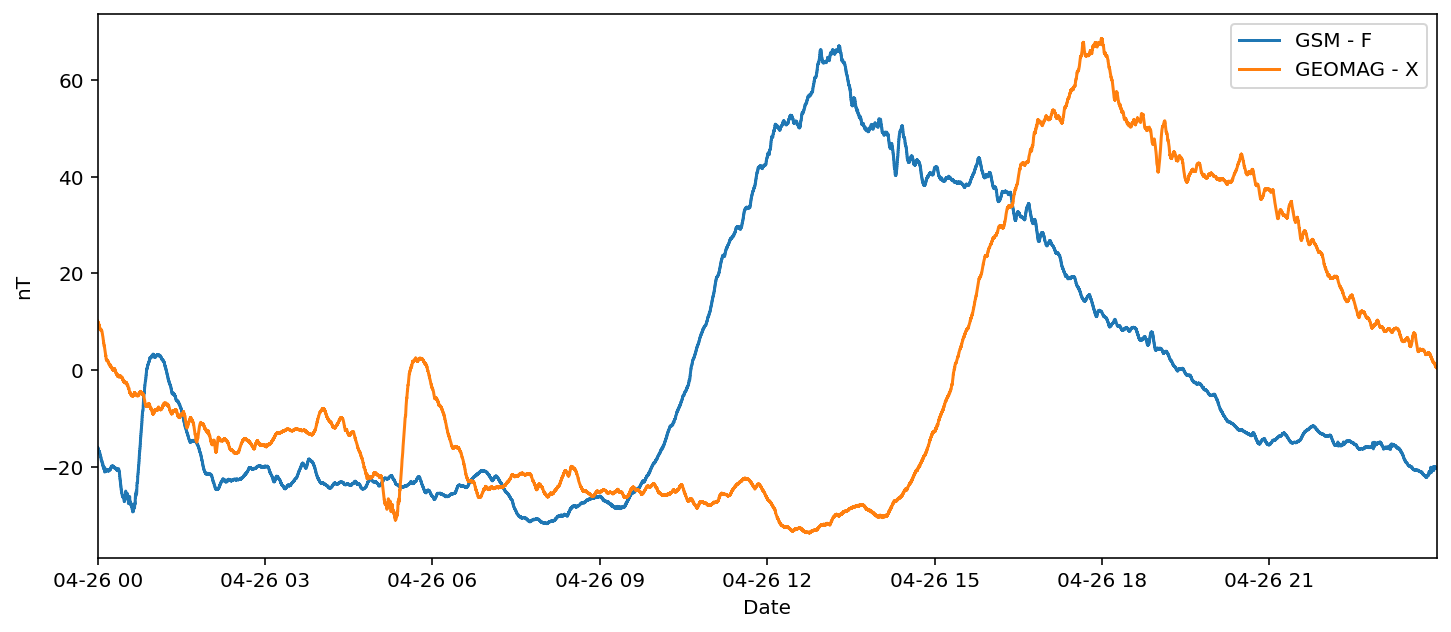

In [13]:
plt.figure(figsize = (12,5))

plt.plot(df_ppm['F'] - df_ppm['F'].mean(), label =  'GSM - F')
plt.plot(df_sec['X'] - df_sec['X'].mean(), label = 'GEOMAG - X')

plt.xlim(df_ppm.index[0], df_ppm.index[-1])
plt.xlabel('Date')
plt.ylabel('nT')
plt.legend()

plt.show()

Now, lets use the pd.corr to calculate the correlation coeficiente between them. The default method is Pearson correlation coefficient.

In [5]:
print('The correlation coefficient before the correction is:',df_ppm['F'].corr(df_sec['X']).round(5))

The correlation coefficient before the correction is: -0.32035


We expect the maximum aplitude of the time series around 12h, because of the solar wind. Therefore, it is possible to conclude that the GEOMAG is the equipment qith problem.

The script roll one time series over the other and compute the correlation coefficient. The best one is stored with the respective time shift used in the calculation.

The arguments window_start, window_end and step controls the window that will be analyzed.

In [14]:
tsc.time_shift_corre_coef(obs = 'MAA0',
                          start_date= '2021-04-26',
                          end_date='2021-04-26',
                          window_start = 14000,
                          window_end = 18000,
                          step = 1,
                          shift_direction= 'backward'
                         )

shifting the data to find the best adjust for 20210426


,coef,Shift-Time,Date,Time-seconds
2941,0.999994,4:42:21,20210426,16941


The best correlation coefficient was 0.999989, indicating that the time series are delayed by 04:44:01 or 17041 seconds, as was used the shift_direction 'backward', the time found is negative.

Let's apply the found time shift and see how the data looks like in comparison with the previous figure.

C:\Users\marco\AppData\Local\Temp\ipykernel_20872\4282058533.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tight_layout" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('time_shift.jpeg', dpi =300, tight_layout = True)


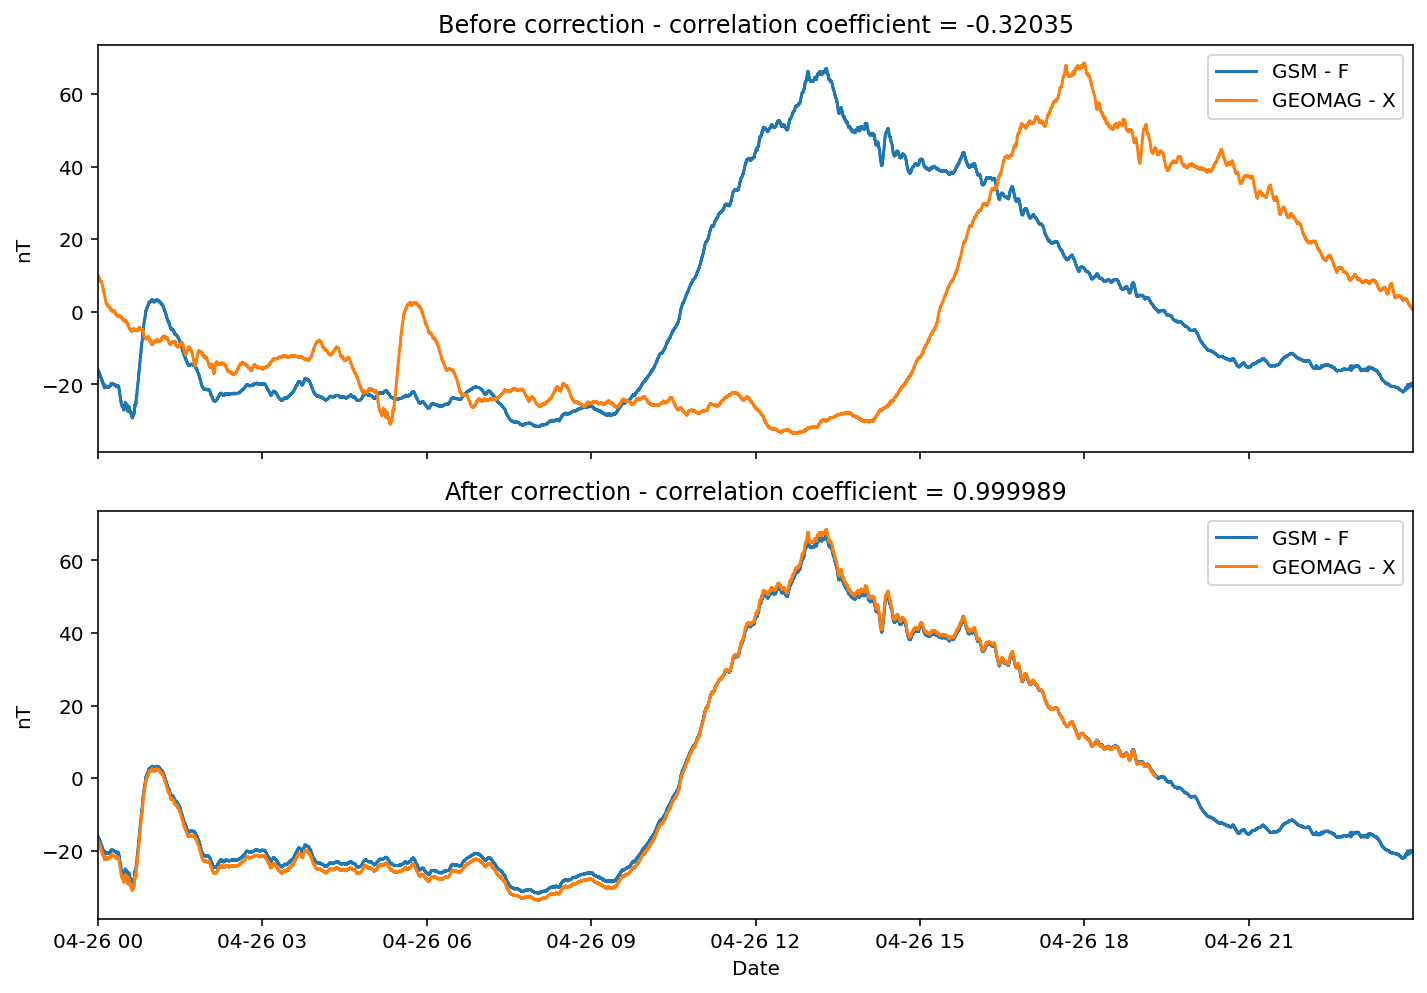

In [15]:
fig, ax = plt.subplots(2,1, figsize = (10,7), sharex = True)

ax[0].plot(df_ppm['F'] - df_ppm['F'].mean(), label =  'GSM - F')
ax[0].plot((df_sec['X'] - df_sec['X'].mean()), label = 'GEOMAG - X')

ax[0].set_xlim(df_ppm.index[0], df_ppm.index[-1])
ax[0].set_ylabel('nT')
ax[0].set_title(f'Before correction - correlation coefficient = -0.32035')
ax[0].legend()



ax[1].plot(df_ppm['F'] - df_ppm['F'].mean(), label =  'GSM - F')
ax[1].plot((df_sec['X'] - df_sec['X'].mean()).shift(-16941, freq = 's'), label = 'GEOMAG - X')

ax[1].set_xlim(df_ppm.index[0], df_ppm.index[-1])
ax[1].set_title(f'After correction - correlation coefficient = 0.999989')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('nT')
ax[1].legend()

fig.tight_layout(pad=1)
plt.savefig('time_shift.jpeg', dpi =300, tight_layout = True)
plt.show()

With a zoom in any "disturbed" moment is possible to visually identify the good synchronization.

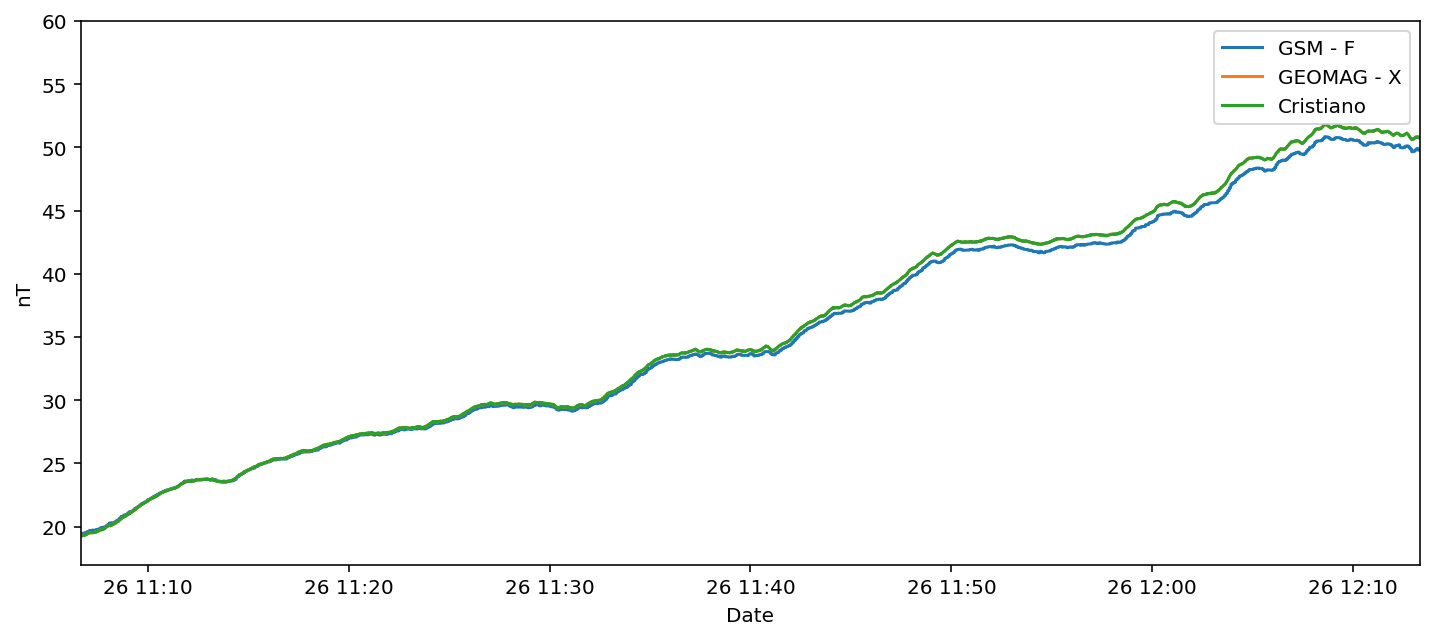

In [19]:
plt.figure(figsize = (12,5))

plt.plot(df_ppm['F'] - df_ppm['F'].mean(), label =  'GSM - F')
plt.plot((df_sec['X'] - df_sec['X'].mean()).shift(-16941, freq = 's'), label = 'GEOMAG - X')
plt.plot((df_sec['X'] - df_sec['X'].mean()).shift(-16941, freq = 's'), label = 'Cristiano')

plt.xlim(df_ppm.index[40000], df_ppm.index[44000])
plt.ylim(17,60)
plt.xlabel('Date')
plt.ylabel('nT')
plt.legend()

plt.show()

In [10]:
df_ppm['F'].corr(df_sec['X'].shift(-17040, freq = 's'))

0.9999888596688039

In [ ]:
0.999989
0.999988
